In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -3 -4"))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision

import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import display_seg
from curriculum_deeplab.mindssc import mindssc

import curriculum_deeplab.ml_data_parameters_utils as ml_data_parameters_utils
import wandb
import random
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  -------------
   1  NVIDIA GeForce RTX 2080 Ti     0 %    6637 MiB  11.5(495.29.05)  popp
   0  NVIDIA GeForce RTX 2080 Ti     0 %    4760 MiB  11.5(495.29.05)  falta, germer
   3  NVIDIA GeForce RTX 2080 Ti     0 %    2083 MiB  11.5(495.29.05)  falta
   2  NVIDIA GeForce RTX 2080 Ti    27 %    5683 MiB  11.5(495.29.05)  germer

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   1  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.1+cu102
7605
NVIDIA GeForce RTX 2080 Ti


In [2]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv3d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            # nn.AdaptiveAvgPool2d(1),
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-3:]
        # x = F.adaptive_avg_pool3d(x, (1))
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='nearest')  # , align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = [nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())]

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)
 
        self.project = nn.Sequential(
            nn.Conv3d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


# Mobile-Net with depth-separable convolutions and residual connections
class ResBlock(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs


def create_model(output_classes: int = 14,input_channels: int = 1):
    # in_channels = torch.Tensor([1,16,24,24,32,32,32,64]).long()
    in_channels = torch.Tensor([input_channels, 24, 24, 32, 48, 48, 48, 64]).long()
    mid_channels = torch.Tensor([64, 128, 192, 192, 256, 256, 256, 384]).long()
    out_channels = torch.Tensor([24, 24, 32, 48, 48, 48, 64, 64]).long()
    mid_stride = torch.Tensor([1, 1, 1, 2, 1, 1, 1, 1])
    net = [nn.Identity()]
    for i in range(8):
        inc = int(in_channels[i])
        midc = int(mid_channels[i])
        outc = int(out_channels[i])
        strd = int(mid_stride[i])
        layer = nn.Sequential(nn.Conv3d(inc, midc, 1, bias=False), nn.BatchNorm3d(midc), nn.ReLU6(True),
                              nn.Conv3d(midc, midc, 3, stride=strd, padding=1, bias=False, groups=midc),
                              nn.BatchNorm3d(midc), nn.ReLU6(True),
                              nn.Conv3d(midc, outc, 1, bias=False), nn.BatchNorm3d(outc))
        if i == 0:
            layer[0] = nn.Conv3d(inc, midc, 3, padding=1, stride=2, bias=False)
        if (inc == outc) & (strd == 1):
            net.append(ResBlock(layer))
        else:
            net.append(layer)

    backbone = nn.Sequential(*net)

    count = 0
    # weight initialization
    for m in backbone.modules():
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            count += 1
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.zeros_(m.bias)

    print('#CNN layer', count)
    # complete model: MobileNet + ASPP + head (with a single skip connection)
    # newer model (one more stride, no groups in head)
    aspp = ASPP(64, (2, 4, 8, 16, 32), 128)
    head = nn.Sequential(nn.Conv3d(128 + 24, 64, 1, padding=0, groups=1, bias=False), nn.BatchNorm3d(64), nn.ReLU(), \
                         nn.Conv3d(64, 64, 3, groups=1, padding=1, bias=False), nn.BatchNorm3d(64), nn.ReLU(), \
                         nn.Conv3d(64, output_classes, 1))
    return backbone, aspp, head


def apply_model(backbone, aspp, head, img, checkpointing=True, return_intermediate=False):
    if checkpointing:
        x1 = checkpoint(backbone[:3], img)
        x2 = checkpoint(backbone[3:], x1)
        y = checkpoint(aspp, x2)
        y1 = torch.cat((x1, F.interpolate(y, scale_factor=2)), 1)
        output_j = checkpoint(head, y1)
    else:
        x1 = backbone[:3](img)
        x2 = backbone[3:](x1)
        y = aspp(x2)
        y1 = torch.cat((x1, F.interpolate(y, scale_factor=2)), 1)
        output_j = head(y1)
    if return_intermediate:
        return y1,output_j
    else:
        return output_j


In [17]:
def interpolate_sample(b_image, b_label, scale_factor, yield_2d):
    
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'
    
    b_image = F.interpolate(
        b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True
    )

    b_label = F.interpolate(
        b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest').long()
    
    return b_image.squeeze(1), b_label.squeeze(1)



def dilate_label_class(b_label, class_max_idx, class_dilate_idx, 
                       yield_2d, kernel_sz=3):
    
    b_dilated_label = b_label
    
    b_onehot = torch.nn.functional.one_hot(b_label.long(), class_max_idx+1)
    class_slice = b_onehot[...,class_dilate_idx]
    
    pad_start, pad_end = int(kernel_sz//2)-((kernel_sz+1)%2), int(kernel_sz//2)

    if yield_2d:
        B, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz]).long()
        kernel = kernel.view(1,1,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv2d(
            class_slice.view(B,1,H,W), kernel, 
            padding=(pad_start, pad_end))
        
    else:
        B, D, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz,kernel_sz])
        kernel = kernel.long().view(1,1,kernel_sz,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv3d(
            class_slice.view(B,1,D,H,W), kernel, padding=(pad_start, pad_end))
        
    dilated_class_slice = torch.clamp(class_slice.squeeze(0), 0, 1)
    b_dilated_label[dilated_class_slice.bool()] = class_dilate_idx
    
    return b_dilated_label


def get_batch_dice_wo_bg(b_dice) -> float:
    if torch.all(torch.isnan(b_dice[:,1:])):
        return float('nan')
    return np.nanmean(b_dice[:,1:]).item()
    
    

def get_batch_dice_tumour(b_dice) -> float: 
    if torch.all(torch.isnan(b_dice[:,1])):
        return float('nan')
    return np.nanmean(b_dice[:,1]).item()



def get_batch_dice_cochlea(b_dice) -> float:
    if torch.all(torch.isnan(b_dice[:,2])):
        return float('nan')
    return np.nanmean(b_dice[:,2]).item()
    
    
    
def map_continuous_from_dataset_idxs(subset_to_map, dataset_idxs):
    cont_idxs = torch.tensor([torch.where(dataset_idxs==d_idx) for d_idx in subset_to_map]).reshape(subset_to_map.shape)
    return cont_idxs



def get_2d_stack_batch_size(b_input_size: torch.Size, stack_dim):
    assert len(b_input_size) == 5, f"Input size must be 5D: BxCxDxHxW but is {b_input_size}"
    if stack_dim == "D":
        return b_input_size[0]*b_input_size[2]
    if stack_dim == "H":
        return b_input_size[0]*b_input_size[3]
    if stack_dim == "W":
        return b_input_size[0]*b_input_size[4]
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")

        
        
def make_2d_stack_from_3d(b_input, stack_dim):
    assert b_input.dim() == 5, f"Input must be 5D: BxCxDxHxW but is {b_input.shape}"
    B, C, D, H, W = b_input.shape
    
    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4).reshape(B*D, C, H, W)
    if stack_dim == "H":
        return b_input.permute(0, 3, 1, 2, 4).reshape(B*H, C, D, W)
    if stack_dim == "W":
        return b_input.permute(0, 4, 1, 2, 3).reshape(B*W, C, D, H)
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")
        
    
    
def make_3d_from_2d_stack(b_input, stack_dim, orig_stack_size):
    assert b_input.dim() == 4, f"Input must be 4D: (orig_batch_size/B)xCxSPAT1xSPAT0 but is {b_input.shape}"
    B, C, SPAT1, SPAT0 = b_input.shape
    b_input = b_input.reshape(orig_stack_size, int(B//orig_stack_size), C, SPAT1, SPAT0)

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4)
    if stack_dim == "H":
        return b_input.permute(0, 2, 3, 1, 4)
    if stack_dim == "W":
        return b_input.permute(0, 2, 3, 4, 1)
    else:
        raise ValueError(f"stack_dim is '{stack_dim}' but must be 'D' or 'H' or 'W'.")

In [18]:
def augmentBspline(b_image, b_label, num_ctl_points=7, strength=0.05, yield_2d=False):
    """
    2D/3D b-spline augmentation on image and segmentation mini-batch on GPU.
    :input: b_image batch (torch.cuda.FloatTensor), b_label batch (torch.cuda.LongTensor)
    :return: augmented Bx(D)xHxW image batch (torch.cuda.FloatTensor), 
    augmented Bx(D)xHxW seg batch (torch.cuda.LongTensor)
    """

    KERNEL_SIZE = 3

    if yield_2d:
        assert b_image.dim() == b_label.dim() == 3, \
            f"Augmenting 2D. Input batch of image and " \
            f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        B,H,W = b_image.shape
        
        bspline = torch.nn.Sequential(
            nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2))
        )
        # Add an extra *.5 factor to dim strength to make strength fit 3D case
        dim_strength = (torch.tensor([H,W]).float()*strength*.5).to(b_image.device)
        rand_control_points = dim_strength.view(1,2,1,1) * torch.randn(
            1, 2, num_ctl_points, num_ctl_points
        ).to(b_image.device)
        
        bspline_disp = bspline(rand_control_points)
        bspline_disp = torch.nn.functional.interpolate(
            bspline_disp, size=(H,W), mode='bilinear', align_corners=True
        ).permute(0,2,3,1)
    
        identity = torch.eye(2,3).expand(B,2,3).to(b_image.device)
        
        id_grid = F.affine_grid(identity, torch.Size((B,2,H,W)), 
            align_corners=False)

    else:
        assert b_image.dim() == b_label.dim() == 4, \
            f"Augmenting 3D. Input batch of image and " \
            f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"
        B,D,H,W = b_image.shape
        
        bspline = torch.nn.Sequential(
            nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
            nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2))
        )
        dim_strength = (torch.tensor([D,H,W]).float()*strength).to(b_image.device)
        rand_control_points = dim_strength.view(1,3,1,1,1) * torch.randn(
            1, 3, num_ctl_points, num_ctl_points, num_ctl_points
        ).to(b_image.device)

        bspline_disp = bspline(rand_control_points)

        bspline_disp = torch.nn.functional.interpolate(
            bspline_disp, size=(D,H,W), mode='trilinear', align_corners=True
        ).permute(0,2,3,4,1)
    
        identity = torch.eye(3,4).expand(B,3,4).to(b_image.device)
        
        id_grid = F.affine_grid(identity, torch.Size((B,3,D,H,W)), 
            align_corners=False)

    b_image_out = F.grid_sample(
        b_image.unsqueeze(1).float(), id_grid + bspline_disp, 
        padding_mode='border', align_corners=False)
    b_label_out = F.grid_sample(
        b_label.unsqueeze(1).float(), id_grid + bspline_disp, 
        mode='nearest', align_corners=False)

    return b_image_out.squeeze(1), b_label_out.squeeze(1).long()



def augmentAffine(b_image, b_label, strength=0.05, yield_2d=False):
    """
    2D/3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: b_image batch (torch.cuda.FloatTensor), b_label batch (torch.cuda.LongTensor)
    :return: augmented Bx(D)xHxW image batch (torch.cuda.FloatTensor), 
    augmented Bx(D)xHxW seg batch (torch.cuda.LongTensor)
    """
    if yield_2d:
        assert b_image.dim() == b_label.dim() == 3, \
            f"Augmenting 2D. Input batch of image and " \
            f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        B,H,W = b_image.shape
        
        affine_matrix = (torch.eye(2,3).unsqueeze(0) + torch.randn(B,2,3) \
                         * strength).to(b_image.device)

        meshgrid = F.affine_grid(affine_matrix, torch.Size((B,1,H,W)), 
                                 align_corners=False)
    else:
        assert b_image.dim() == b_label.dim() == 4, \
            f"Augmenting 3D. Input batch of image and " \
            f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"
        B,D,H,W = b_image.shape
        
        affine_matrix = (torch.eye(3,4).unsqueeze(0) + torch.randn(B,3,4) \
                         * strength).to(b_image.device)

        meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)), 
                                 align_corners=False)
        
    b_image_out = F.grid_sample(
        b_image.unsqueeze(1).float(), meshgrid, padding_mode='border', align_corners=False)
    b_label_out = F.grid_sample(
        b_label.unsqueeze(1).float(), meshgrid, mode='nearest', align_corners=False)

    return b_image_out.squeeze(1), b_label_out.squeeze(1).long()



def augmentNoise(b_image, strength=0.05):
    return b_image + strength*torch.randn_like(b_image)

In [19]:
from pathlib import Path

class CrossMoDa_Data(Dataset):
    def __init__(self,
        base_dir, domain, state,
        ensure_labeled_pairs=True, use_additional_data=False, resample=True,
        size:tuple=(96,96,60), normalize:bool=True, 
        max_load_num=None, crop_w_dim_range=None,
        disturbed_idxs=None, yield_2d_normal_to=None, flip_r_samples=True,
        dilate_kernel_sz=3):
        
        """
        Function to create Dataset structure with crossMoDa data.
        The function allows to use different preproccessing steps of the crossMoDa data set
        and using additinal data from TCIA database.
        The data can also be resampled to a desired size and normalized to mean=0 and std=1.

        Parameters:
                base_dir (os.Pathlike): provide the directory which contains "L1..." to "L4..." directories
                domain (str): choose which domain to load. Can be set to "source", "target" or "validation". Source are ceT1, target and validation hrT2 images.

                state (str): state of preprocessing:    "l1" = original data,
                                                        "l2" = resampled data @ 0.5mm,
                                                        "l3" = center-cropped data,
                                                        "l4" = image specific crops for desired anatomy

                ensure_labeled_pairs (bool): Only images with corresponding labels will be loaded (default: True)
                
                use_additional_data (bool): set to True to use additional data from TCIA (default: False)

                resample (bool): set to False to disable resampling to desired size (default: True)

                size (tuple): 3d-tuple(int) to which the data is resampled. Unused if resample=False. (default: (96,96,60)).
                    WARNING: choosing large sizes or not resampling can lead to excess memory usage

                normalize (bool): set to False to disable normalization to mean=0, std=1 for each image (default: True)
                max_load_num (int): maximum number of pairs to load (uses first max_load_num samples for either images and labels found)
                crop_w_dim_range (tuple): Tuple of ints defining the range to which dimension W of (D,H,W) is cropped
                yield_2d_normal_to (bool):
                
        Returns:
                torch.utils.data.Dataset containing CrossMoDa data

        Useful Links:
        CrossMoDa challenge:
        https://crossmoda.grand-challenge.org/

        ToDos:
            extend to other preprocessing states

        Example:
            dataset = CrossMoDa_source('original')

            data = dataset.get_data()

        """
        
        self.disturbed_idxs = disturbed_idxs
        self.yield_2d_normal_to = yield_2d_normal_to
        self.do_train = False
        self.augment_at_collate = False
        self.dilate_kernel_sz = dilate_kernel_sz
        
        #define finished preprocessing states here with subpath and default size
        states = {
            'l1':('L1_original/', (512,512,160)),
            'l2':('L2_resampled_05mm/', (420,420,360)),
            'l3':('L3_coarse_fixed_crop/', (128,128,192)),
            'l4':('L4_fine_localized_crop/', (128,128,128))
        }
        t0 = time.time()
        #choose directory with data according to chosen preprocessing state
        if state not in states: raise Exception("Unknown state. Choose one of: "+str(states.keys))
        
        state_dir = states[state.lower()][0] #get sub directory
        
        if not resample: size = states[state.lower()][1] #set size to default defined at top of file
        
        path = base_dir + state_dir
        
        #get file list
        if domain.lower() =="ceT1" or domain.lower() =="source":
            directory = "source_training_labeled/"
            add_directory = "__additional_data_source_domain__"
            domain = "ceT1"
            
        elif domain.lower() =="hrT2" or domain.lower() =="target":
            directory = "target_training_unlabeled/"
            add_directory = "__additional_data_target_domain__"
            domain = "hrT2"
            
        elif domain.lower() =="validation":
            directory = "target_validation_unlabeled/"
            
        else:
            raise Exception("Unknown domain. Choose either 'source', 'target' or 'validation'")
        
        files = sorted(glob.glob(os.path.join(path+directory , "*.nii.gz")))

        if domain == "hrT2":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_training__" , "*.nii.gz")))
        
        if domain.lower() == "validation":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_validation__" , "*.nii.gz")))
        
        if use_additional_data and domain.lower() != "validation": #add additional data to file list
            files = files+sorted(glob.glob(os.path.join(path+add_directory , "*.nii.gz")))
            files = [i for i in files if "additionalLabel" not in i] #remove additional label files

        # First read filepaths
        self.img_paths = {}
        self.label_paths = {}

        for _path in files:
     
            numeric_id = int(re.findall(r'\d+', os.path.basename(_path))[0])
            if "_l.nii.gz" in _path or "_l_Label.nii.gz" in _path:
                lr_id = 'l'
            elif "_r.nii.gz" in _path or "_r_Label.nii.gz" in _path:
                lr_id = 'r'
            else:
                lr_id = ""
            
            # Generate crossmoda id like 004r
            crossmoda_id = f"{numeric_id:03d}{lr_id}"
            
            if "Label" in _path:
                self.label_paths[crossmoda_id] = _path
                    
            elif domain in _path:
                self.img_paths[crossmoda_id] = _path
        
        if ensure_labeled_pairs:
            pair_idxs = set(self.img_paths).intersection(set(self.label_paths))
            self.label_paths = {_id: _path for _id, _path in self.label_paths.items() if _id in pair_idxs}
            self.img_paths = {_id: _path for _id, _path in self.img_paths.items() if _id in pair_idxs}
        
            
        # Populate data
        self.img_data = {}
        self.label_data = {}
        self.img_data_2d = {}
        self.label_data_2d = {}
        
        #load data
        
        print("Loading CrossMoDa {} images and labels...".format(domain))
        id_paths_to_load = list(self.label_paths.items()) + list(self.img_paths.items())
        
        description = f"{len(self.img_paths)} images, {len(self.label_paths)} labels"

        for crossmoda_id, f in tqdm(id_paths_to_load, desc=description):
            # tqdm.write(f"Loading {f}")
            if "Label" in f:
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='nearest').squeeze()
                
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                    
                if crop_w_dim_range:
                    tmp = tmp[..., crop_w_dim_range[0]:crop_w_dim_range[1]]    
                
                self.label_data[crossmoda_id] = tmp.long()
                    
            elif domain in f:
                tmp = torch.from_numpy(nib.load(f).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='trilinear',align_corners=False).squeeze()
                
                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)
                
                if crop_w_dim_range:
                    tmp = tmp[..., crop_w_dim_range[0]:crop_w_dim_range[1]]
                    
                if normalize: #normalize image to zero mean and unit std
                    tmp = (tmp - tmp.mean()) / tmp.std()
                    
                self.img_data[crossmoda_id] = tmp
        
        # Postprocessing
        for crossmoda_id in list(self.label_data.keys()):
            if self.label_data[crossmoda_id].unique().numel() != 3:
                del self.img_data[crossmoda_id]
                del self.label_data[crossmoda_id]
            elif "r" in crossmoda_id:
                self.img_data[crossmoda_id] = self.img_data[crossmoda_id].flip(dims=(1,))
                self.label_data[crossmoda_id] = self.label_data[crossmoda_id].flip(dims=(1,))
        
        if max_load_num and ensure_labeled_pairs:
            for crossmoda_id in list(self.label_data.keys())[max_load_num:]:
                del self.img_data[crossmoda_id]
                del self.label_data[crossmoda_id]
                
        elif max_load_num:
            for del_key in list(self.image_data.keys())[max_load_num:]:
                del self.img_data[crossmoda_id]
            for del_key in list(self.label_data.keys())[max_load_num:]:
                del self.label_data[crossmoda_id]
            
        #check for consistency
        print("Equal image and label numbers: {}".format(set(self.img_data)==set(self.label_data)))
        
        img_stack = torch.stack(list(self.img_data.values()), dim=0)
        img_mean, img_std = img_stack.mean(), img_stack.std()
        
        label_stack = torch.stack(list(self.label_data.values()), dim=0)

        print("Image shape: {}, mean.: {:.2f}, std.: {:.2f}".format(img_stack.shape, img_mean, img_std))
        print("Label shape: {}, max.: {}".format(label_stack.shape,torch.max(label_stack)))
        
        if yield_2d_normal_to:
            if yield_2d_normal_to == "D":
                slice_dim = -3
            if yield_2d_normal_to == "H":
                slice_dim = -2
            if yield_2d_normal_to == "W":
                slice_dim = -1
  
            for crossmoda_id, image in self.img_data.items():  
                for idx, img_slc in [(slice_idx, image.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(image.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.img_data_2d[f"{crossmoda_id}{yield_2d_normal_to}{idx:03d}"] = img_slc
                    
            for crossmoda_id, label in self.label_data.items():   
                for idx, lbl_slc in [(slice_idx, label.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(label.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.label_data_2d[f"{crossmoda_id}{yield_2d_normal_to}{idx:03d}"] = lbl_slc
                    
        print("Data import finished. Elapsed time: {:.1f} s".format(time.time()-t0 ))
        print(f"CrossMoDa loader will yield {'2D' if self.yield_2d_normal_to else '3D'} samples")
        
    def get_crossmoda_ids(self):
        return sorted(list(
            set(self.img_data.keys())
            .union(set(self.label_data.keys()))
        ))
    
    def get_2d_crossmoda_ids(self):
        return sorted(list(
            set(self.img_data_2d.keys())
            .union(set(self.label_data_2d.keys()))
        ))
    
    def get_crossmoda_id_dicts(self):
        
        all_crossmoda_ids = self.get_crossmoda_ids()
        id_dicts = []
        
        for twod_dataset_idx, twod_crossmoda_id in enumerate(self.get_2d_crossmoda_ids()):
            crossmoda_id = twod_crossmoda_id[:-4]
            id_dicts.append(
                {
                    '2d_crossmoda_id': twod_crossmoda_id,
                    '2d_dataset_idx': twod_dataset_idx,
                    'crossmoda_id': crossmoda_id,
                    'dataset_idx': all_crossmoda_ids.index(crossmoda_id),                    
                }
            )
        
        return id_dicts
        
    def __len__(self, yield_2d_override=None):
        if yield_2d_override == None:
            # Here getting 2D or 3D data length
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override
            
        if yield_2d:
            return len(self.img_data_2d)
        
        return len(self.img_data)

    def __getitem__(self, dataset_idx, yield_2d_override=None):
        
        if yield_2d_override == None:
            # Here getting 2D or 3D data can be overridden
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override
        
        modified_label = []
        
        if yield_2d:
            all_crossmoda_ids = self.get_2d_crossmoda_ids()
            c_id = all_crossmoda_ids[dataset_idx]
            image = self.img_data_2d.get(c_id, torch.tensor([]))
            label = self.label_data_2d.get(c_id, torch.tensor([]))
            
            # For 2D crossmoda id cut last 4 "003rW100"
            image_path = self.img_paths[c_id[:-4]]
            label_path = self.label_paths[c_id[:-4]]
            
        else:
            all_crossmoda_ids = self.get_crossmoda_ids()
            c_id = all_crossmoda_ids[dataset_idx]
            image = self.img_data.get(c_id, torch.tensor([]))
            label = self.label_data.get(c_id, torch.tensor([]))

            image_path = self.img_paths[c_id]
            label_path = self.label_paths[c_id]
        
        if self.do_train:
            # In case of training add augmentation, modification and
            # disturbance
            
            if not self.augment_at_collate:
                b_image = image.unsqueeze(0)
                b_label = label.unsqueeze(0)
                b_image, b_label = self.augment(b_image, b_label, yield_2d)
                image = b_image.squeeze(0)
                label = b_label.squeeze(0)
            
            # Dilate small cochlea segmentation
            COCHLEA_CLASS_IDX = 2
            pre_mod = b_label.squeeze(0)
            modified_label = dilate_label_class(
                b_label.detach().clone(), COCHLEA_CLASS_IDX, COCHLEA_CLASS_IDX, 
                yield_2d=yield_2d, kernel_sz=self.dilate_kernel_sz
            ).squeeze(0)

            if self.disturbed_idxs != None and dataset_idx in self.disturbed_idxs:
                if yield_2d:
                    modified_label = \
                        torch.flip(modified_label, dims=(-2,-1))
                else:
                    modified_label = \
                        torch.flip(modified_label, dims=(-3,-2,-1))
        
        if yield_2d:
            assert image.dim() == label.dim() == 2
        else:
            assert image.dim() == label.dim() == 3
            
        return {
            'image': image,
            'label': label,
            'modified_label': modified_label,
            'dataset_idx': dataset_idx, 
            'crossmoda_id': c_id, 
            'image_path': image_path, 
            'label_path': label_path
        }
    
    def get_crossmoda_3d_item(self, dataset_idx):
        return self.__getitem__(dataset_idx, yield_2d_override=False)

    def get_data(self):
        img_stack = torch.stack(list(self.img_data.values()), dim=0)
        label_stack = torch.stack(list(self.label_data.values()), dim=0)
        
        return img_stack, label_stack
    
    def set_disturbed_idxs(self, idxs):
        self.disturbed_idxs = idxs
        
    def train(self):
        self.do_train = True
        
    def eval(self):
        self.do_train = False
        
    def set_augment_at_collate(self):
        self.augment_at_collate = True
    
    def unset_augment_at_collate(self):
        self.augment_at_collate = False
    
    def set_dilate_kernel_size(self, sz):
        
        self.dilate_kernel_sz = max(0,sz)
        
    def get_dilate_kernel_size(self):
        return self.dilate_kernel_sz
        
    def get_efficient_augmentation_collate_fn(self):
        yield_2d = True if self.yield_2d_normal_to else False
        
        def collate_closure(batch):
            batch = torch.utils.data._utils.collate.default_collate(batch)
            if self.augment_at_collate:
                # Augment the whole batch not just one sample
                b_image = batch['image'].cuda()
                b_label = batch['label'].cuda()
                b_image, b_label = self.augment(b_image, b_label, yield_2d)
                batch['image'], batch['label'] = b_image.cpu(), b_label.cpu()

            return batch
        
        return collate_closure
    
    def augment(self, b_image, b_label, yield_2d):
        
        # Wrap image tensor and label with ScalarImage and LabelMap:
        # 

        # Prepare dims for torchio: All transformed 
        # images / labels need to be 4-dim;
        # 2D images need to have dims=1xHxWx1 to make transformation work
        
        if yield_2d:
            assert b_image.dim() == b_label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        else:
            assert b_image.dim() == b_label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"

        spatial_aug_selector = np.random.rand()
        
        b_image, b_label = interpolate_sample(b_image, b_label, 2., yield_2d)
        if spatial_aug_selector < .4:
            b_image, b_label = augmentAffine(
                b_image, b_label, strength=0.05, yield_2d=yield_2d)

        elif spatial_aug_selector <.8:
            b_image, b_label = augmentBspline(
                b_image, b_label, num_ctl_points=7, strength=0.005, yield_2d=yield_2d)
        else:
            pass
        b_image, b_label = interpolate_sample(b_image, b_label, .5, yield_2d)
        
        b_image = augmentNoise(b_image, strength=0.05)
        b_label = b_label.long()
        
        return b_image, b_label

In [20]:
config_dict = {
    'num_folds': 3,
    'only_first_fold': True,
    
    'num_classes': 3,
    'use_mind': True,
    'epochs': 120,
    
    'batch_size': 64,
    'val_batch_size': 1,
    
    'train_set_max_len': 100,
    'crop_w_dim_range': (24, 110),
    'yield_2d_normal_to': "W",
    
    'lr': 0.0005,
    
    # Data parameter config
    'data_param_optim_momentum': .5,
    'init_class_param': 1.0, 
    'learn_class_parameters': False, 
    'lr_class_param': 0.1,
    'init_inst_param': 1.0, 
    'learn_inst_parameters': False, 
    'lr_inst_param': 0.1,
    'wd_inst_param': 0.0,
    'wd_class_param': 0.0,
    
    'skip_clamp_data_param': False,
    'clamp_inst_sigma_config': {
        'min': np.log(1/20),
        'max': np.log(20)
    },
    'clamp_cls_sigma_config': {
        'min': np.log(1/20),
        'max': np.log(20)
    },

    'log_every': 1,
    'mdl_save_prefix': 'data/models',
    
    'do_plot': False,
    'debug': False,
    'wandb_mode': "online",

    'disturbed_flipped_num': 0,
    'start_disturbing_after_ep': 1000000,
    
    'start_dilate_kernel_sz': 7
}

In [ ]:
training_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
    domain="source", state="l4", size=(128, 128, 128),
    ensure_labeled_pairs=True, 
    max_load_num=config_dict['train_set_max_len'], 
    crop_w_dim_range=config_dict['crop_w_dim_range'],
    yield_2d_normal_to=config_dict['yield_2d_normal_to'],
    dilate_kernel_sz=config_dict['start_dilate_kernel_sz']
)
# validation_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="validation", state="l4", ensure_labeled_pairs=True)
# target_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/", 
#     domain="target", state="l4", ensure_labeled_pairs=True)

torch.Size([100, 128, 128, 86])


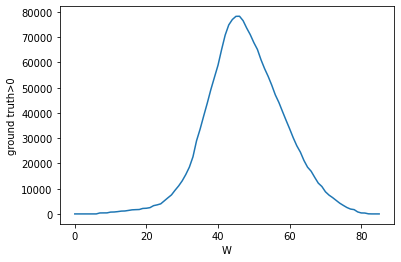

In [8]:
_, all_labels = training_dataset.get_data()
print(all_labels.shape)
# D_stack = make_2d_stack_from_3d(all_labels.unsqueeze(1), "D")
# print(D_stack.shape)
sum_over_w = torch.sum(all_labels, dim=(0,1,2))
plt.xlabel("W")
plt.ylabel("ground truth>0")
plt.plot(sum_over_w);

In [9]:
if config_dict['do_plot']:
    # Print bare 2D data
    # print("Displaying 2D bare sample")
    # for img, label in zip(training_dataset.img_data_2d.values(), 
    #                       training_dataset.label_data_2d.values()):
    #     display_seg(in_type="single_2D",
    #                 img=img.unsqueeze(0), 
    #                 ground_truth=label,
    #                 crop_to_non_zero_gt=True,
    #                 alpha_gt = .3)
        
    # Print transformed 2D data
    # training_dataset.train()
    # print("Displaying 2D training sample")
    # for sample in training_dataset:
    #     display_seg(in_type="single_2D",
    #                 img=sample['image'].unsqueeze(0), 
    #                 ground_truth=sample['label'],
    #                 crop_to_non_zero_gt=True,
    #                 alpha_gt = .3)

    # Print transformed 3D data
    training_dataset.train()
    print("Displaying 3D training sample")
    leng = 1# training_dataset.__len__(yield_2d_override=False)
    for sample in (training_dataset.get_crossmoda_3d_item(idx) for idx in range(leng)):
        # training_dataset.set_dilate_kernel_size(1)
        display_seg(in_type="single_3D", reduce_dim="W",
                    img=sample['image'].unsqueeze(0), 
                    ground_truth=sample['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)
        
        # training_dataset.set_dilate_kernel_size(7)
        display_seg(in_type="single_3D", reduce_dim="W",
                    img=sample['image'].unsqueeze(0), 
                    ground_truth=sample['modified_label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)


In [10]:
if config_dict['do_plot']:
    for sidx in [1,]:
        print(f"Sample {sidx}:")
        
        training_dataset.eval()
        sample_eval = training_dataset.get_crossmoda_3d_item(sidx)

        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=sample_eval['image'].unsqueeze(0), 
                    ground_truth=sample_eval['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)
        
        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=sample_eval['image'].unsqueeze(0), 
                    ground_truth=sample_eval['label'], 
                    crop_to_non_zero_gt=True,
                    alpha_gt = .0)

        training_dataset.train()
        print("Train sample with ground-truth overlay")
        sample_train = training_dataset.get_crossmoda_3d_item(sidx)
        print(sample_train['label'].unique())
        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=sample_train['image'].unsqueeze(0), 
                    ground_truth=sample_train['label'], 
                    crop_to_non_zero_gt=True,
                    alpha_gt=.3)

        print("Eval/train diff with diff overlay")
        display_seg(in_type="single_3D", reduce_dim="W", 
                    img=(sample_eval['image'] - sample_train['image']).unsqueeze(0), 
                    ground_truth=(sample_eval['label'] - sample_train['label']).clamp(min=0), 
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)

In [11]:
# train_subset = torch.utils.data.Subset(training_dataset,range(2))
if config_dict['do_plot']:
    train_plotset = (training_dataset.get_crossmoda_3d_item(idx) for idx in (55, 81, 63))
    for sample in train_plotset:
        print(f"Sample {sample['dataset_idx']}:")
        display_seg(in_type="single_3D", reduce_dim="W", 
            img=sample_eval['image'].unsqueeze(0), 
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .6)
        display_seg(in_type="single_3D", reduce_dim="W", 
            img=sample_eval['image'].unsqueeze(0), 
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .0)

In [12]:
#Add functions to replace modules of a model

import functools
MOD_GET_FN = lambda self, key: self[int(key)] if isinstance(self, nn.Sequential) \
                                              else getattr(self, key)

def get_module(module, keychain):
    """Retrieves any module inside a pytorch module for a given keychain.
       module.named_ to retrieve valid keychains for layers.
    """

    return functools.reduce(MOD_GET_FN, keychain.split('.'), module)

def set_module(module, keychain, replacee):
    """Replaces any module inside a pytorch module for a given keychain with "replacee".
       Use get_named_layers_leaves(module) to retrieve valid keychains for layers.
    """
    
    key_list = keychain.split('.')
    root = functools.reduce(MOD_GET_FN, key_list[:-1], module)
    leaf = key_list[-1]
    if isinstance(root, nn.Sequential):
        root[int(leaf)] = replacee
    else:
        setattr(root, leaf, replacee)

In [13]:
def save_model(lraspp, inst_parameters, class_parameters, 
    optimizer, optimizer_inst_param, optimizer_class_param, 
    scaler, _path):
    
    torch.save(lraspp.state_dict(), _path + '_lraspp.pth')
    
    torch.save(inst_parameters, _path + '_inst_parameters.pth')
    torch.save(class_parameters, _path + '_class_parameters.pth')
    
    torch.save(optimizer.state_dict(), _path + '_optimizer.pth')
    torch.save(optimizer_inst_param.state_dict(), _path + '_optimizer_inst_param.pth')
    torch.save(optimizer_class_param.state_dict(), _path + '_optimizer_class_param.pth')
    
    torch.save(scaler.state_dict(), _path + '_grad_scaler.pth')

    
    
def get_model(config, dataset_len, _path=None):
    if config.use_mind:
        in_channels = 12
    else:
        in_channels = 1

    lraspp = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=False, progress=True, num_classes=config.num_classes)
    set_module(lraspp, 'backbone.0.0', torch.nn.Conv2d(in_channels, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False))
        
    optimizer = torch.optim.Adam(lraspp.parameters(), lr=config.lr)
    
    (class_parameters, inst_parameters, optimizer_class_param, optimizer_inst_param) = \
        ml_data_parameters_utils.get_class_inst_data_params_n_optimizer(config,
            config.init_class_param, config.learn_class_parameters, config.lr_class_param,
            config.init_inst_param, config.learn_inst_parameters, config.lr_inst_param,
            nr_classes=config.num_classes,
            nr_instances=dataset_len,
            device='cuda'
        )
    
    scaler = amp.GradScaler()
    
    if _path and os.path.isfile(_path + '_lraspp.pth'):
        print(f"Loading lr-aspp model, data parameters, optimizers and grad scalers from {_path}")
        lraspp.load_state_dict(torch.load(_path + '_lraspp.pth', map_location='cuda'))

        inst_parameters = torch.load(_path + '_inst_parameters.pth', map_location='cuda')
        class_parameters = torch.load(_path + '_class_parameters.pth', map_location='cuda')

        optimizer.load_state_dict(torch.load(_path + '_optimizer.pth', map_location='cuda'))
        optimizer_inst_param.load_state_dict(torch.load(_path + '_optimizer_inst_param.pth', map_location='cuda'))
        optimizer_class_param.load_state_dict(torch.load(_path + '_optimizer_class_param.pth', map_location='cuda'))

        scaler.load_state_dict(torch.load(_path + '_grad_scaler.pth', map_location='cuda'))
    else:
        print("Loading fresh lr-aspp model, data parameters, optimizers and grad scalers.")
        
    return (lraspp, inst_parameters, class_parameters, 
        optimizer, optimizer_inst_param, optimizer_class_param, 
        scaler)

In [14]:
def get_global_idx(fold_idx, epoch_idx, max_epochs):
    # Get global index e.g. 2250 for fold_idx=2, epoch_idx=250 @ max_epochs<1000
    return 10**len(str(int(max_epochs)))*fold_idx + epoch_idx
        
    
            
def log_n_largest_data_parameters(parameter_idxs, parameters, log_path, n=10):
    data = [[inst_idx, val] for (inst_idx, val) in \
        zip(parameter_idxs, torch.exp(parameters).tolist())]

    data.sort(key=lambda x: x[1], reverse=True)

    data = data[:n]
    table = wandb.Table(data=data, columns = ["parameter_idx", "value"])
    wandb.log({log_path : wandb.plot.bar(table, "parameter_idx", "value", title=log_path)})
    
    
    
def get_largest_data_parameters_in_target_ratio(parameter_idxs, parameters, target_idxs):
    # print("param_idxs", parameter_idxs)
    # print("parameters", parameters)
    # print("target_idxs", target_idxs)
    data = [[inst_idx, val] for (inst_idx, val) in \
        zip(parameter_idxs, torch.exp(parameters).tolist())]
    
    topk_cont_idxs = torch.argsort(parameters, descending=True)[:len(target_idxs)]
    # print("topk_cont_idxs", topk_cont_idxs)
    topk_dataset_idxs = parameter_idxs[topk_cont_idxs]
    # print("topk_dataset_idxs", topk_dataset_idxs)
    ratio = np.sum(np.in1d(topk_dataset_idxs, target_idxs))/len(target_idxs)
    
    return ratio
    
    
    
def reset_determinism():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    # torch.use_deterministic_algorithms(True)

In [15]:
def train_DL(run_name, config, training_dataset):
    reset_determinism()

    # Configure folds
    kf = KFold(n_splits=config.num_folds)
    kf.get_n_splits(training_dataset)
    
    fold_iter = enumerate(kf.split(training_dataset))

    if config.only_first_fold:
        fold_iter = list(fold_iter)[0:1]
    
    if config.wandb_mode != 'disabled':
        # Log dataset info
        training_dataset.eval()
        dataset_info = [[smp['dataset_idx'], smp['crossmoda_id'], smp['image_path'], smp['label_path']] \
                        for smp in training_dataset]
        wandb.log({'datasets/training_dataset':wandb.Table(columns=['dataset_idx', 'crossmoda_id', 'image', 'label'], data=dataset_info)}, step=0)
 
    fold_means_no_bg = []

    for fold_idx, (train_idxs, val_idxs) in fold_iter:
        train_idxs = torch.tensor(train_idxs)
        val_idxs = torch.tensor(val_idxs)
        
        # Training happens in 2D, validation happens in 3D:
        # Read 2D dataset idxs which are used for training, 
        # get their 3D super-ids by 3d dataset length
        # and substract these from all 3D ids to get val_3d_idxs
        trained_3d_dataset_idxs = {dct['dataset_idx'] \
             for dct in training_dataset.get_crossmoda_id_dicts() if dct['2d_dataset_idx'] in train_idxs.tolist()}
        val_3d_idxs = set(range(training_dataset.__len__(yield_2d_override=False))) - trained_3d_dataset_idxs
        print("Will run validation with these 3D samples:", val_3d_idxs)
        
        ### Disturb dataset ###
        disturbed_idxs = np.random.choice(train_idxs, size=config.disturbed_flipped_num, replace=False)
        disturbed_idxs = torch.tensor(disturbed_idxs)
        
        clean_idxs = train_idxs[np.isin(train_idxs, disturbed_idxs, invert=True)]
        print("Disturbed indexes:", sorted(disturbed_idxs.tolist()))
        
        if clean_idxs.numel() < 200:
            print(f"Clean indexes: {sorted(clean_idxs.tolist())}")

        wandb.log({f'datasets/disturbed_idxs_fold{fold_idx}':wandb.Table(columns=['train_idxs'], data=[[idx] for idx in disturbed_idxs])}, 
            step=get_global_idx(fold_idx, 0, config.epochs))
        
        ### Visualization ###
        if config.do_plot:
            print("Disturbed samples:")
            for d_idx in disturbed_idxs:
                display_seg(in_type="single_3D", reduce_dim="W", 
                    img=training_dataset[d_idx][0], 
                    ground_truth=disturb_seg(training_dataset[d_idx][1]),
                    crop_to_non_zero_gt=True,
                    alpha_gt = .0)
        
        ### Configure MIND ###
        if config.use_mind:
            in_channels =12
        else:
            in_channels = 1
            
        _, all_segs = training_dataset.get_data()

        # TODO add class weights again
        # class_weight = torch.sqrt(1.0/(torch.bincount(all_segs.long().view(-1)).float()))
        # class_weight = class_weight/class_weight.mean()
        # class_weight[0] = 0.15
        # class_weight = class_weight.cuda()
        # print('inv sqrt class_weight', class_weight)
        
        ### Add train sampler and dataloaders ##
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        # val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

        train_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, 
            sampler=train_subsampler, pin_memory=True, drop_last=False,
            collate_fn=training_dataset.get_efficient_augmentation_collate_fn())
        training_dataset.unset_augment_at_collate()
#         val_dataloader = DataLoader(training_dataset, batch_size=config.val_batch_size, 
#                                     sampler=val_subsampler, pin_memory=True, drop_last=False)
      
        ### Get model, data parameters, optimizers for model and data parameters, as well as grad scaler ###
        (lraspp, inst_parameters, class_parameters, optimizer, optimizer_inst_param, 
         optimizer_class_param, scaler) = get_model(config, len(train_dataloader), _path=None)#f"{config.mdl_save_prefix}_fold{fold_idx}") # TODO start fresh set _path None
        
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=200, T_mult=2, eta_min=config.lr*.1, last_epoch=- 1, verbose=False)
        
        lraspp.cuda()
        inst_parameters = inst_parameters.cuda()
        class_parameters = class_parameters.cuda()
        
        # criterion = nn.CrossEntropyLoss(class_weight)
        criterion = nn.CrossEntropyLoss()

        top1 = ml_data_parameters_utils.AverageMeter('Acc@1', ':6.2f')
        top5 = ml_data_parameters_utils.AverageMeter('Acc@5', ':6.2f')
        
        t0 = time.time()

        for epx in range(config.epochs):
            global_idx = get_global_idx(fold_idx, epx, config.epochs)
        
            lraspp.train()
            training_dataset.train()
            
            optimizer.zero_grad()
            if config.learn_class_parameters:
                optimizer_class_param.zero_grad()
            if config.learn_inst_parameters:
                optimizer_inst_param.zero_grad()

            ### Disturb samples ###
            do_disturb = epx > config.start_disturbing_after_ep
            wandb.log({"do_disturb": float(do_disturb)}, step=global_idx)

            if do_disturb:
                training_dataset.set_disturbed_idxs(disturbed_idxs)
            else:
                training_dataset.set_disturbed_idxs([])
                
            epx_losses = []
            dices = []
            dices_tumour = []
            dices_cochlea = []
            
            # Load data
            for batch in train_dataloader:
                
                b_img = batch['image']
                b_seg = batch['label']
                b_seg_modified = batch['modified_label']
                b_idxs_dataset = batch['dataset_idx']

                b_img = b_img.float().cuda()
                b_seg_modified = b_seg_modified.cuda()
        
                b_seg = b_seg.cuda()
    
                if config.use_mind:
                    b_img = mindssc(b_img.unsqueeze(1).unsqueeze(1)).squeeze(2)

                ### Forward pass ###
                with amp.autocast(enabled=True):
                    assert b_img.dim() == 4, \
                        f"Input image for model must be 4D: BxCxHxW but is {b_img.shape}"
                    
                    logits = lraspp(b_img)['out']

                    if config.learn_class_parameters or config.learn_inst_parameters:
                        # TODO change class parameters
                        # Compute data parameters for instances in the minibatch
                        class_parameter_minibatch = torch.tensor([0])
                        # class_parameter_minibatch = class_parameters[b_seg_modified] TODO: Readd that again
                        cont_idxs = map_continuous_from_dataset_idxs(b_idxs_dataset, train_idxs)
                        inst_parameter_minibatch = inst_parameters[cont_idxs]

                        data_parameter_minibatch = ml_data_parameters_utils.get_data_param_for_minibatch(
                                                        learn_class_parameters=config.learn_class_parameters, 
                                                        learn_inst_parameters=config.learn_inst_parameters,
                                                        class_param_minibatch=class_parameter_minibatch,
                                                        inst_param_minibatch=inst_parameter_minibatch)

                        # Compute logits scaled by data parameters
                        logits = logits / data_parameter_minibatch.view([-1] + [1]*(logits.dim()-1))


                    ### Calculate loss ###
                    assert logits.dim() == 4, \
                        f"Input shape for loss must be BxNUM_CLASSESxHxW but is {logits.shape}"
                    assert b_seg_modified.dim() == 3, \
                        f"Target shape for loss must be BxHxW but is {b_seg_modified.shape}"
    
                    loss = criterion(logits, b_seg_modified)

                    ### Apply weight decay on data parameters##
                    if config.learn_class_parameters or config.learn_inst_parameters:
                        loss = ml_data_parameters_utils.apply_weight_decay_data_parameters(
                            config.learn_inst_parameters, config.wd_inst_param,
                            config.learn_class_parameters, config.wd_class_param,
                            loss,
                            class_parameter_minibatch=class_parameter_minibatch,
                            inst_parameter_minibatch=inst_parameter_minibatch)

                scaler.scale(loss).backward()
                scaler.step(optimizer)

                if config.learn_class_parameters:
                    scaler.step(optimizer_class_param)
                if config.learn_inst_parameters:
                    scaler.step(optimizer_inst_param)

                scaler.update()

                # Clamp class and instance level parameters within certain bounds
                if config.learn_class_parameters or config.learn_inst_parameters:
                    ml_data_parameters_utils.clamp_data_parameters(
                        config.skip_clamp_data_param, config.learn_inst_parameters, config.learn_class_parameters,
                        class_parameters, inst_parameters,
                        config.clamp_inst_sigma_config, config.clamp_cls_sigma_config)
                    
                epx_losses.append(loss)
                
                # Prepare logits for scoring
                logits_for_score = logits.argmax(1)

                # Calculate dice score
                dice = dice2d(
                    torch.nn.functional.one_hot(logits_for_score, 3),
                    torch.nn.functional.one_hot(b_seg, 3), # Calculate dice score with original segmentation (no disturbance)
                    one_hot_torch_style=True
                )

                dices.append(get_batch_dice_wo_bg(dice))
                dices_tumour.append(get_batch_dice_tumour(dice))
                dices_cochlea.append(get_batch_dice_cochlea(dice))
                
                if config.do_plot:
                    print("Training 2D stack image label/ground-truth")
                    print(dice)
                    
                    display_seg(in_type="batch_2D", 
                        img=batch['image'].unsqueeze(1).cpu(), 
                        seg=logits_for_score.cpu(),
                        ground_truth=b_seg.cpu(),
                        crop_to_non_zero_seg=True,
                        crop_to_non_zero_gt=True,
                        alpha_seg=.1,
                        alpha_gt =.2
                    )
                    
                if config.debug:
                    break
                    
                ###  Scheduler management ###
                scheduler.step()

                if scheduler.T_cur == 0:
                    sz = training_dataset.get_dilate_kernel_size()
                    print("sz is", sz)
                    training_dataset.set_dilate_kernel_size(sz-1)
                    print(f"Current dilate kernel size is {training_dataset.get_dilate_kernel_size()}.")

            ### Logging ###
            if epx % config.log_every == 0 or (epx+1 == config.epochs):
                           
                ### Log wandb data ###
                # Log the epoch idx per fold - so we can recover the diagram by setting 
                # ref_epoch_idx as x-axis in wandb interface
                print(f'epx_fold{fold_idx}{epx} {time.time()-t0:.2f}s')
                wandb.log({"ref_epoch_idx": epx}, step=global_idx)
                
                mean_loss = torch.tensor(epx_losses).mean()
                mean_dice = np.nanmean(dices)
                mean_dice_tumour = np.nanmean(dices_tumour)
                mean_dice_cochlea = np.nanmean(dices_cochlea)
                
                print()
                print(f'loss_fold{fold_idx} {mean_loss:.6f}')
                print(f'dice_mean_wo_bg_fold{fold_idx}', f"{mean_dice*100:.2f}%")
                print(f'dice_mean_tumour_fold{fold_idx}', f"{mean_dice_tumour*100:.2f}%")
                print(f'dice_mean_cochlea_fold{fold_idx}', f"{mean_dice_cochlea*100:.2f}%")
                wandb.log({f'losses/loss_fold{fold_idx}': mean_loss}, step=global_idx)
                wandb.log({f'scores/dice_mean_wo_bg_fold{fold_idx}': mean_dice}, step=global_idx)
                wandb.log({f'scores/dice_mean_tumour_fold{fold_idx}': mean_dice_tumour}, step=global_idx)
                wandb.log({f'scores/dice_mean_cochlea_fold{fold_idx}': mean_dice_cochlea}, step=global_idx)
            
                # Log data parameters of disturbed samples
                if disturbed_idxs.numel() > 0:
                    cont_idxs_disturbed = map_continuous_from_dataset_idxs(disturbed_idxs, train_idxs)
                    ml_data_parameters_utils.log_intermediate_iteration_stats(
                        "data_parameters/disturbed/", f"_fold{fold_idx}",
                        global_idx,
                        config.learn_class_parameters, config.learn_inst_parameters,
                        class_parameters, inst_parameters[cont_idxs_disturbed], top1, top5)

                    # Log data parameters of clean samples
                    cont_idxs_clean = map_continuous_from_dataset_idxs(clean_idxs, train_idxs)
                    ml_data_parameters_utils.log_intermediate_iteration_stats(
                        "data_parameters/clean/", f"_fold{fold_idx}",
                        global_idx,
                        config.learn_class_parameters, config.learn_inst_parameters,
                        class_parameters, inst_parameters[cont_idxs_clean], top1, top5)
                
                    # Calculate ratio of data parameters in topN disturbed (is 1.0 if every disturbed
                    # sample gets the highest data parameter)
                    inst_param_ratio = get_largest_data_parameters_in_target_ratio(
                        train_idxs, inst_parameters, disturbed_idxs
                    )
            
                    print(f'data_param_ratio_fold{fold_idx}', inst_param_ratio)
                    wandb.log(
                        {f'data_parameters/inst_param_largest_in_target_ratio_fold{fold_idx}': inst_param_ratio}, 
                        step=global_idx
                    )
                
                ## Validation ###
                                                    
                lraspp.eval()
                training_dataset.eval()   
                # TODO remove saving 
                # save_model(lraspp, inst_parameters, class_parameters, 
                #     optimizer, optimizer_inst_param, optimizer_class_param, 
                #     scaler, f"{config.mdl_save_prefix}_fold{fold_idx}")
                
                with amp.autocast(enabled=True):
                    with torch.no_grad():
                        val_dices = []
                        val_dices_tumour = []
                        val_dices_cochlea = []
                        
                        for val_idx in val_3d_idxs:
                            val_sample = training_dataset.get_crossmoda_3d_item(val_idx)
                            stack_dim = training_dataset.yield_2d_normal_to
                            # Create batch out of single val sample
                            b_val_img = val_sample['image'].unsqueeze(0)
                            b_val_seg = val_sample['label'].unsqueeze(0)
                            
                            B = b_val_img.shape[0]

                            b_val_img = b_val_img.unsqueeze(1).float().cuda()
                            b_val_seg = b_val_seg.cuda()
                            b_val_img_2d = make_2d_stack_from_3d(b_val_img, stack_dim=stack_dim)
                            
                            if config.use_mind:
                                b_val_img_2d = mindssc(b_val_img_2d.unsqueeze(1)).squeeze(2)
                                
                            output_val = lraspp(b_val_img_2d)['out']

                            # Prepare logits for scoring
                            # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
                            val_logits_for_score = make_3d_from_2d_stack(output_val, stack_dim, B)
                            val_logits_for_score = val_logits_for_score.argmax(1)

                            val_dice = dice3d(
                                torch.nn.functional.one_hot(val_logits_for_score, 3),
                                torch.nn.functional.one_hot(b_val_seg, 3), 
                                one_hot_torch_style=True
                            )
                            val_dices.append(get_batch_dice_wo_bg(val_dice))
                            val_dices_tumour.append(get_batch_dice_tumour(val_dice))
                            val_dices_cochlea.append(get_batch_dice_cochlea(val_dice))
                            
                            if config.do_plot:
                                print(f"Validation 3D image label/ground-truth {val_3d_idxs}")
                                print(val_dice)
                                # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                                display_seg(in_type="single_3D", 
                                    reduce_dim="W",
                                    img=val_sample['image'].unsqueeze(0).cpu(), 
                                    seg=val_logits_for_score.squeeze(0).cpu(),
                                    ground_truth=b_val_seg.squeeze(0).cpu(),
                                    crop_to_non_zero_seg=True,
                                    crop_to_non_zero_gt=True,
                                    alpha_seg=.4,
                                    alpha_gt=.2
                                )
                        mean_val_dice = np.nanmean(val_dices)
                        mean_val_dice_tumour = np.nanmean(val_dices_tumour)
                        mean_val_dice_cochlea = np.nanmean(val_dices_cochlea)
                        
                        print(f'val_dice_mean_wo_bg_fold{fold_idx}', f"{mean_val_dice*100:.2f}%")
                        print(f'val_dice_mean_tumour_fold{fold_idx}', f"{mean_val_dice_tumour*100:.2f}%")
                        print(f'val_dice_mean_cochlea_fold{fold_idx}', f"{mean_val_dice_cochlea*100:.2f}%")
                        wandb.log({f'scores/val_dice_mean_wo_bg_fold{fold_idx}': mean_val_dice}, step=global_idx)
                        wandb.log({f'scores/val_dice_mean_tumour_fold{fold_idx}': mean_val_dice_tumour}, step=global_idx)
                        wandb.log({f'scores/val_dice_mean_cochlea_fold{fold_idx}': mean_val_dice_cochlea}, step=global_idx)
                        print(val_dices, len(val_dices))
            if config.debug:
                break
                
        # End of fold loop        
        log_n_largest_data_parameters(train_idxs, inst_parameters, 
            f"data_parameters/largest_instance_parameters_fold{fold_idx}", n=30
        )
        
        log_n_largest_data_parameters(train_idxs, inst_parameters, 
            f"data_parameters/all_instance_parameters_fold{fold_idx}", n=len(training_dataset)
        )

        lraspp.cpu()
        
        save_model(lraspp, inst_parameters, class_parameters, 
            optimizer, optimizer_inst_param, optimizer_class_param, 
            scaler, f"{config.mdl_save_prefix}_fold{fold_idx}")

In [16]:
config_dict['debug'] = False
config_dict['wandb_mode'] = 'online'

run = wandb.init(project="curriculum_deeplab", group="training", job_type="train",
    config=config_dict, settings=wandb.Settings(start_method="thread"),
    mode=config_dict['wandb_mode']
)

run_name = run.name
config = wandb.config

train_DL(run_name, config, training_dataset)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Will run validation with these 3D samples: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
Disturbed indexes: []
Loading fresh lr-aspp model, data parameters, optimizers and grad scalers.
7
7
7
7
7
7
7
7
7
7
7
7


/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


KeyboardInterrupt: 

In [ ]:
def inference_DL(run_name, config, inf_dataset):

    score_dicts = []
    
    fold_iter = range(config.num_folds)
    if config_dict['only_first_fold']:
        fold_iter = fold_iter[0:1]
        
    for fold_idx in fold_iter:
        lraspp, *_ = load_model(f"{config.mdl_save_prefix}_fold{fold_idx}", config, len(validation_dataset))

        lraspp.eval()
        inf_dataset.eval()   
        stack_dim = config.yield_2d_normal_to
        
        inf_dices = []
        inf_dices_tumour = []
        inf_dices_cochlea = []
        
        for inf_sample in inf_dataset:
            global_idx = get_global_idx(fold_idx, sample_idx, config.epochs)
            crossmoda_id = sample['crossmoda_id']
            with amp.autocast(enabled=True):
                with torch.no_grad():

                    # Create batch out of single val sample
                    b_inf_img = inf_sample['image'].unsqueeze(0)
                    b_inf_seg = inf_sample['label'].unsqueeze(0)

                    B = b_inf_img.shape[0]

                    b_inf_img = b_inf_img.unsqueeze(1).float().cuda()
                    b_inf_seg = b_inf_seg.cuda()
                    b_inf_img_2d = make_2d_stack_from_3d(b_inf_img, stack_dim=stack_dim)

                    if config.use_mind:
                        b_inf_img_2d = mindssc(b_inf_img_2d.unsqueeze(1)).squeeze(2)

                    output_inf = lraspp(b_inf_img_2d)['out']

                    # Prepare logits for scoring
                    # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
                    inf_logits_for_score = make_3d_from_2d_stack(output_inf, stack_dim, B)
                    inf_logits_for_score = inf_logits_for_score.argmax(1)

                    inf_dice = dice3d(
                        torch.nn.functional.one_hot(inf_logits_for_score, 3),
                        torch.nn.functional.one_hot(b_inf_seg, 3), 
                        one_hot_torch_style=True
                    )
                    inf_dices.append(get_batch_dice_wo_bg(inf_dice))
                    inf_dices_tumour.append(get_batch_dice_tumour(inf_dice))
                    inf_dices_cochlea.append(get_batch_dice_cochlea(inf_dice))

                    if config.do_plot:
                        print("Inference 3D image label/ground-truth")
                        print(inf_dice)
                        # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                        display_seg(in_type="single_3D", 
                            reduce_dim="W",
                            img=inf_sample['image'].unsqueeze(0).cpu(), 
                            seg=inf_logits_for_score.squeeze(0).cpu(),
                            ground_truth=b_inf_seg.squeeze(0).cpu(),
                            crop_to_non_zero_seg=True,
                            crop_to_non_zero_gt=True,
                            alpha_seg=.4,
                            alpha_gt=.2
                        )
                        
            if config.debug:
                break
                
        mean_inf_dice = np.nanmean(inf_dices)
        mean_inf_dice_tumour = np.nanmean(inf_dices_tumour)
        mean_inf_dice_cochlea = np.nanmean(inf_dices_cochlea)

        print(f'inf_dice_mean_wo_bg_fold{fold_idx}', f"{mean_inf_dice*100:.2f}%")
        print(f'inf_dice_mean_tumour_fold{fold_idx}', f"{mean_inf_dice_tumour*100:.2f}%")
        print(f'inf_dice_mean_cochlea_fold{fold_idx}', f"{mean_inf_dice_cochlea*100:.2f}%")
        wandb.log({f'scores/inf_dice_mean_wo_bg_fold{fold_idx}': mean_inf_dice}, step=global_idx)
        wandb.log({f'scores/inf_dice_mean_tumour_fold{fold_idx}': mean_inf_dice_tumour}, step=global_idx)
        wandb.log({f'scores/inf_dice_mean_cochlea_fold{fold_idx}': mean_inf_dice_cochlea}, step=global_idx)

        # Store data for inter-fold scoring
        class_dice_list = inf_dices.tolist()[0]
        for class_idx, class_dice in enumerate(class_dice_list):
            score_dicts.append(
                {
                    'fold_idx': fold_idx,
                    'crossmoda_id': crossmoda_id,
                    'class_idx': class_idx,
                    'class_dice': class_dice,
                }
            )

    mean_oa_inf_dice = np.nanmean(torch.tensor([score['class_dice'] for score in score_dicts]))
    print(f"Mean dice over all folds, classes and samples: {mean_oa_inf_dice*100:.2f}%")
    wandb.log({'scores/mean_dice_all_folds_samples_classes': mean_oa_inf_dice}, step=global_idx)

    return score_dicts

In [ ]:
folds_scores = []
run = wandb.init(project="curriculum_deeplab", name=run_name, group=f"testing", job_type="test",
        config=config_dict, settings=wandb.Settings(start_method="thread"),
        mode=config_dict['wandb_mode']
)
config = wandb.config
score_dicts = inference_DL(run_name, config, validation_dataset)
folds_scores.append(score_dicts)
wandb.finish()